# Mismatch analysis tool

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from shifting_baseline.utils.log import get_logger, adjust_log_level

# 获取项目模块的 logger
log = get_logger()

# 在 notebook 中动态调整日志等级
adjust_log_level(console_level="INFO", file_level="DEBUG")

In [3]:
from shifting_baseline.data import load_data
from hydra import compose, initialize

with initialize(config_path="../config", version_base=None):
    cfg = compose(config_name="config")

# 加载数据
combined, uncertainties, history = load_data(cfg)
combined.head()

INFO | 加载自然数据 [1000-1900]...
INFO | 从文件加载处理后的自然数据 ...
INFO | 加载历史数据 ...


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:214: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,mean,sd,hdi_3%,hdi_97%
year,,,,
1000,0.293,0.523,-0.687,1.285
1001,-0.022,0.529,-1.017,0.976
1002,0.773,0.614,-0.360,1.929
1003,0.420,0.674,-0.884,1.651
1004,-0.218,0.641,-1.424,0.981


## 测试数据

这里主要是看一下同样的 pattern 是不是在测试阶段 1900-2010 不出现

In [ ]:
from shifting_baseline.filters import classify
from shifting_baseline.calibration import MismatchReport
from shifting_baseline.data import load_validation_data

# 校验数据
_, validation_data = load_validation_data(
    cfg.ds.out.precip_z,
    resolution=cfg.resolution,
    regional_csv=cfg.ds.out.regional_csv,
)

# 数轮数据
tree_ring = combined["mean"]
mismatch_report = MismatchReport(
    pred=classify(validation_data),
    true=classify(tree_ring),
    value_series=tree_ring,
)
mismatch_report

INFO | 有效样本数: 113


MismatchReport(n_samples=113)

INFO | 开始蒙特卡洛模拟 (n=1000)


MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

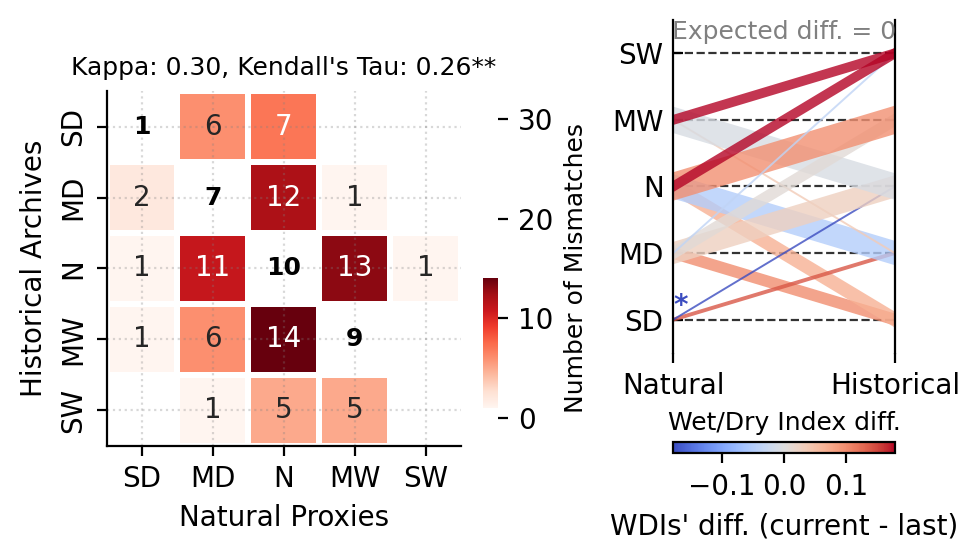

In [5]:
mismatch_report.analyze_error_patterns()
mismatch_report.generate_report_figure();

## 数轮+历史数据对比

In [6]:
history.setup()
pred, true = history.aggregate(
    how=cfg.agg_method,
    to_int=False,
    inplace=True,
).merge_with(
    combined["mean"],
    time_range="2-3",
    split=True,
)

mismatch_report = MismatchReport(
    pred=classify(pred, handle_na="skip"),
    true=classify(true, handle_na="skip"),
    value_series=true,
)
mismatch_report
mismatch_report.analyze_error_patterns()

INFO | 有效样本数: 208


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:214: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


MismatchReport(n_samples=208)

INFO | 开始蒙特卡洛模拟 (n=1000)


MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

true,-2,-1,0,1,2
pred,,,,,
-2,NaN,NaN,NaN,NaN,NaN
-1,0.061857,NaN,-0.113600,-0.056000,NaN
0,NaN,0.020840,NaN,-0.083875,NaN
1,NaN,0.429333,0.060897,NaN,-0.085
2,NaN,NaN,NaN,NaN,NaN


INFO | 报告图表已保存: /Users/songshgeo/Documents/SongshGeo/Outputs/ColMemo_MS/figs/CollMemo_figure2.png


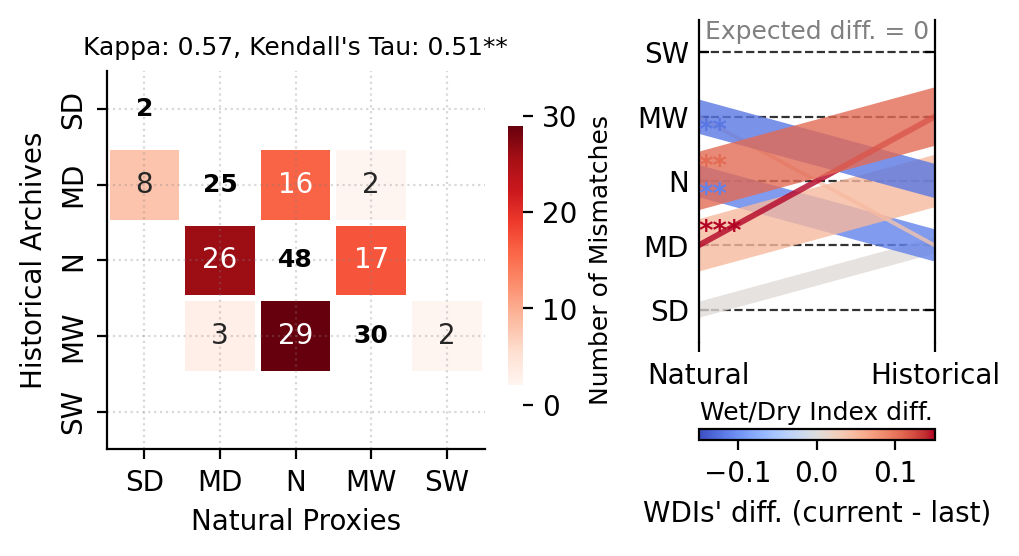

In [11]:
fig = mismatch_report.generate_report_figure(figsize=(5.2, 3), save_path=cfg.ds.fig2)

Figure 1. a: confusion matrix, showing the number of matched (diagonal, white colour) and mismatched (off-diagonal, red colour) judgments of extreme events between natural and recorded levels. b: mismatched between natural and recorded levels. The colour represents the standardised difference between natural and recorded levels. The line width represents the number of mismatches. The line colour represents the standardised difference between this judgement and the previous judgement at the same level. The line transparency represents the significance of the standardised difference (p < 0.05).

In [8]:
mismatch_report.diff_matrix.abs().mean().mean()

0.10582591707717567

### 测试不同的 shift

INFO | 开始蒙特卡洛模拟 (n=1000)


MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO | 开始蒙特卡洛模拟 (n=1000)


MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

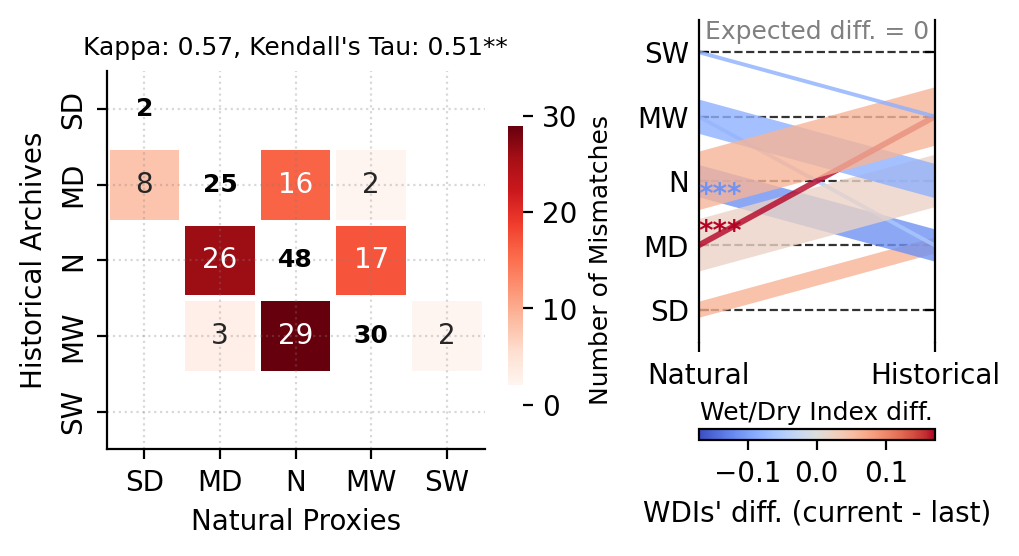

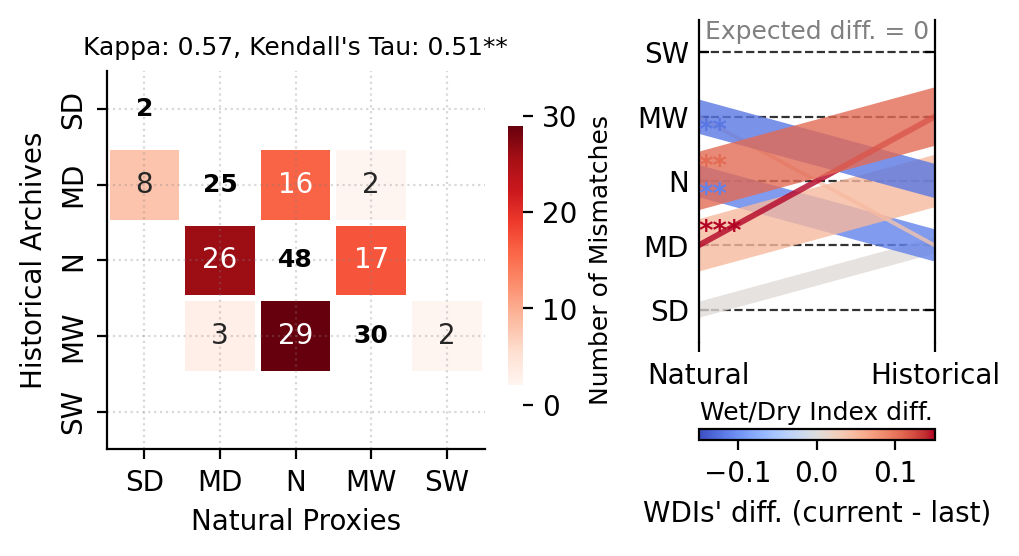

In [9]:
from matplotlib import pyplot as plt

for shift in range(1, 3):
    mismatch_report.analyze_error_patterns(shift=shift)
    mismatch_report.generate_report_figure(figsize=(5.2, 3))
plt.show();

### 保存结果

In [ ]:
import json
import numpy as np

# 读取数据（如果文件损坏就重新创建）
try:
    with open(cfg.ds.results, "r") as f:
        data = json.load(f)
except FileNotFoundError:
    data = {}

# 添加统计数据
results = mismatch_report.get_statistics_summary()
results["mean_diff"] = float(mismatch_report.diff_matrix.abs().mean().mean())

# 转换 NumPy 类型并保留2位小数
for key, value in results.items():
    if isinstance(value, (np.floating, float)):
        results[key] = round(float(value), 2)
    elif isinstance(value, np.integer):
        results[key] = int(value)

data["results2"] = results

# 保存
with open(cfg.ds.results, "w") as f:
    json.dump(data, f, indent=2, ensure_ascii=False)